In [2]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from explicit_functions import dual_control, upstream_repression, no_control, downstream_activation, loss_biological

In [3]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def dual_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss


In [4]:
space = hp.choice('architecture', 
    [('da', [hp.uniform('da_k1', 1E-7, 1E-3), hp.uniform('da_k2', 1E-7, 1E-3), hp.uniform('da_theta1', 0.001, 10), hp.uniform('da_theta2', 0.001, 10)]),
     ('ur', [hp.uniform('ur_k1', 1E-7, 1E-3), hp.uniform('ur_k2', 1E-7, 1E-3), hp.uniform('ur_theta1', 0.001, 10), hp.uniform('ur_theta2', 0.001, 10)]),
     ('nc', [hp.uniform('nc_k1', 1E-7, 1E-3), hp.uniform('nc_k2', 1E-7, 1E-3), hp.uniform('nc_theta1', 0.001, 10), hp.uniform('nc_theta2', 0.001, 10)]),
     ('dc', [hp.uniform('dc_k1', 1E-7, 1E-3), hp.uniform('dc_k2', 1E-7, 1E-3), hp.uniform('dc_theta1', 0.001, 10), hp.uniform('dc_theta2', 0.001, 10)])])
    

In [5]:
losses = []
params = []
circuits = []
def objective(args):
    case, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    
    if case == 'ur':
        ode_function = upstream_repression
    elif case == 'da':
        ode_function = downstream_activation
    elif case == 'dc':
        ode_function = dual_control
    else:
        ode_function = no_control
    
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    losses.append(loss)
    params.append(param_values)
    circuits.append(case)
    return loss
    

In [6]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=5000)
space_eval(space, best)

100%|██████████| 5000/5000 [05:03<00:00, 16.46trial/s, best loss: 0.0634466538743708]


('dc',
 (0.0009245058297479452,
  5.0659671862913046e-05,
  2.485204449928623,
  9.994510515795744))

In [7]:
landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0] for i in range(len(params))], 'k2': [params[i][1] for i in range(len(params))], 'theta1': [params[i][2] for i in range(len(params))], 'theta2': [params[i][3] for i in range(len(params))]})

In [8]:
features = ['k1', 'k2', 'theta1', 'theta2']

x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...


/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.141814


/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.769623
[t-SNE] KL divergence after 300 iterations: 1.882882


Text(0.5, 0.98, 'Multiarchitecture Landscape')

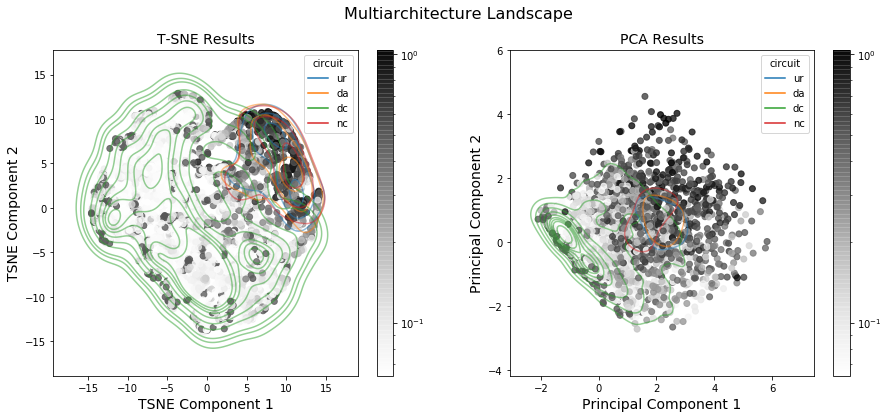

In [10]:
import matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
sns.kdeplot(
    data=landscape,
    x="tsne1",
    y="tsne2",
    hue='circuit',
    thresh=.1, ax=ax, alpha=0.5
)
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greys', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
sns.kdeplot(
    data=landscape,
    x="pc1",
    y="pc2",
    hue='circuit',
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Multiarchitecture Landscape', fontsize=16)
#fig.savefig('multiarchitecture_5000.png')